#### 1. Refer to this section for a description of the problem

__[Kaggle](https://www.kaggle.com/competitions/titanic/data)__ platform provides two datasets (_train.csv_, _test.csv_) containing detailed information about Titanic passengers, such as :
- A unique identifier for each passenger (_PassengerId_) ;
- The class of service in which the passenger traveled (_Pclass_) ;
- The passenger's full name (_Name_) ;
- The gender of the passenger (_Sex_) ;
- The age of the passenger (_Age_) ;
- The number of siblings or spouses accompanying the passenger on the ship (_SibSp_) ;
- The number of parents or children accompanying the passenger on the ship (_Parch_) ;
- The ticket number assigned to the passenger (_Ticket_) ;
- The fare paid by the passenger (_Fare_) ;
- The cabin number assigned to the passenger (_Cabin_) ;
- The port from which the passenger embarked (_Embarked_) ;
- The survival status of the passenger post-collision (_Survived_), which is available only in the _train.csv_ dataset.

Based on the data and relationships identified in the _train.csv_ file, we aim to predict the survival status of passengers listed in the _test.csv_ file following the shipwreck.

#### 2. Import required libraries

In [181]:
import gc, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.stats import kruskal, chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

#### 3. Set up correct path

In [182]:
windowspath__scripts = Path().resolve()
windowspath__data = windowspath__scripts.parent / "data"

#### 4. Import train.csv and test.csv files

In [183]:
df__train = pd.read_csv(filepath_or_buffer=windowspath__data / "train" / "train.csv", dtype=str)
df__test = pd.read_csv(filepath_or_buffer=windowspath__data / "test" / "test.csv", dtype=str)

In [184]:
df__train.sample(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
581,582,1,1,"Thayer, Mrs. John Borland (Marian Longstreth M...",female,39,1,1,17421,110.8833,C68,C
801,802,1,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31,1,1,C.A. 31921,26.25,NaN,S
193,194,1,2,"Navratil, Master. Michel M",male,3,1,1,230080,26,F2,S


In [185]:
df__test.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
91,983,3,"Pedersen, Mr. Olaf",male,NaN,0,0,345498,7.775,NaN,S
359,1251,3,"Lindell, Mrs. Edvard Bengtsson (Elin Gerda Per...",female,30,1,0,349910,15.55,NaN,S
333,1225,3,"Nakid, Mrs. Said (Waika Mary"" Mowad)""",female,19,1,1,2653,15.7417,NaN,C


#### 5. Basic feature engineering (using some of the relations between covariates)

In [186]:
# Define an unified view of df__train and df__test
df__titanic = pd.concat([df__train.copy(deep=True).drop(columns=["Survived"]), df__test.copy(deep=True)], ignore_index=True)

# Tip: samples of df__train and df__test are identified by their PassengerId

df__titanic.sample(n=3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1067,1068,2,"Sincock, Miss. Maude",female,20,0,0,C.A. 33112,36.75,NaN,S
1070,1071,1,"Compton, Mrs. Alexander Taylor (Mary Eliza Ing...",female,64,0,2,PC 17756,83.1583,E45,C
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


##### *5.1. PClass, Ticket, Cabin*

In [187]:
# Remove "Ticket" and "Cabin" since their information can be seen as summarized in "PClass"
df__titanic.drop(columns=["Ticket", "Cabin"], inplace=True)

In [188]:
# Are there missing values in "Pclass" ?
df__titanic[["Pclass"]].isnull().sum()

Pclass    0
dtype: int64

In [189]:
# Rewrite "PClass" feature as "BoardingClass"
# first class is the most privileged, second class is moderately privileged, and third class is the least privileged. 
dict__pclass = {"1": "most privileged", "2": "moderately privileged", "3": "least privileged"}  
df__titanic["BoardingClass"] = df__titanic["Pclass"].map(dict__pclass)

# Cleanup
del df__titanic["Pclass"], dict__pclass

<Axes: title={'center': 'BoardingClass count distribution'}, xlabel='BoardingClass'>

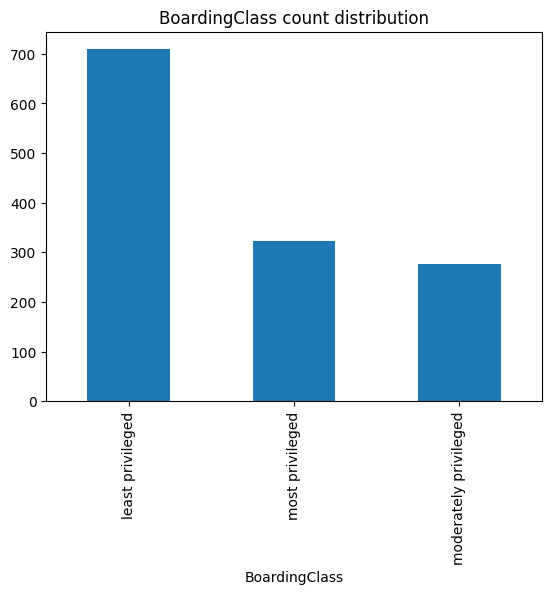

In [190]:
# Take a look at "BoardingClass"
df__titanic["BoardingClass"].value_counts().plot(kind="bar", title="BoardingClass count distribution")

<div style="background-color: green; padding: 10px;">
Half of the passengers on the ship are least privileged people.
</div>

In [191]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Name,Sex,Age,SibSp,Parch,Fare,Embarked,BoardingClass
208,209,"Carr, Miss. Helen ""Ellen""",female,16,0,0,7.75,Q,least privileged
644,645,"Baclini, Miss. Eugenie",female,0.75,2,1,19.2583,C,least privileged
1125,1126,"Cumings, Mr. John Bradley",male,39,1,0,71.2833,C,most privileged


##### *5.2. Name, Sex, Age*

In [192]:
# Are there missing values in "Sex" ?
df__titanic[["Sex"]].isnull().sum()

Sex    0
dtype: int64

In [193]:
# Lowercase "Name" values, and remove periods
df__titanic["Name"] = df__titanic["Name"].apply(lambda x: x.lower().replace(".", ""))

<div style="background-color: green; padding: 10px;">

Research on early 20th-century naming conventions provides insights into titles incorporated in names, which often indicated age or marital status :

- Adult titles : "mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"

- Youth titles : "master", "miss"

- Ambiguous titles : "mlle" (used for both young girls and unmarried women)

Aldulthood for men was 21; whereas for women, it was 18 or 21.

</div>

In [194]:
# Extract a "Title" column from "Name" column

# Define a list of all possible titles
list__adulttitles = ["mr", "mrs", "sir", "rev", "capt", "dr", "col", "major", "ms", "mme", "countess", "don", "jonkheer"]
list__youngtitles = ["master", "miss"]
list__ambiguoustitles = ["mlle"]
list__alltitles = list__adulttitles + list__youngtitles + list__ambiguoustitles

# An example of function to extract title
def function__title(str__name: str) -> str:
    """
    Input:
    str__name : a string (real name and title)
    Output:
    str__title : a string (title)
    """
    for str__title in list__alltitles:
        if str__title in str__name:
            return str__title

# Apply function__title on "Name" column
df__titanic["Title"] = df__titanic["Name"].apply(lambda x: function__title(x))

# Cleanup
del df__titanic["Name"], list__alltitles

<Axes: title={'center': 'Title count distribution'}, xlabel='Title'>

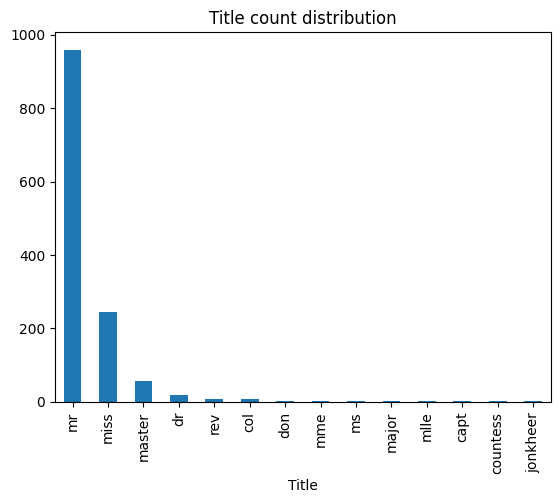

In [195]:
# Take a look at "Title"
df__titanic["Title"].value_counts().plot(kind="bar", title="Title count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship are adult men.
</div>

In [196]:
# Are there missing values in "Age" ?
df__titanic[["Age"]].isnull().sum()

Age    263
dtype: int64

In [197]:
# Set "Age" column data type to decimal number
df__titanic["Age"] = df__titanic["Age"].astype(float)

<div style="background-color: green; padding: 10px;">
Decimals age values can be challenging to interpret. Some of the folks who worked on Titanic problem, explained that these decimals arise when ages are estimated.
</div>

In [198]:
# Analyze the proportion of samples with missing age values
print(f"Of the {len(df__titanic)} samples, {(100*df__titanic["Age"].isnull().sum() / len(df__titanic)):.2f}% have missing age values.")

Of the 1309 samples, 20.09% have missing age values.


In [199]:
# Define a new column "AgeCategory" based on "Title" and "Age"

# An example of function to categorize age
def function__agecategory(str__title: str, float__age: float, float__adulthood = 21.0) -> str:
    """
    Input:
    str__title : a string (title)
    float__age : a decimal number (age)
    float__adulthood : a decimal number (age value to know if adulthood is reached or not)
    Output:
    str__title : a string (title)
    """
    # Test if age value is different of NA
    if float__age != np.nan:
        # Compare its value to adulthood threshold
        if float__age < float__adulthood:
            return "young"
        else: return "adult"
    
    # Test if age value is NA
    if float__age == np.nan:
        # Use title to know if adulthood is reached
        if str__title in list__adulttitles:
            return "adult"
        if str__title in list__youngtitles:
            return "young"
        if str__title in list__ambiguoustitles:
            return "young/adult"

# Apply function__agecategory
df__titanic["AgeCategory"] = df__titanic.apply(lambda row: function__agecategory(str__title=row["Title"], float__age=row["Age"]), axis=1)

# Cleanup
del df__titanic["Age"], df__titanic["Title"], list__adulttitles, list__youngtitles, list__ambiguoustitles

<Axes: title={'center': 'AgeCategory count distribution'}, xlabel='AgeCategory'>

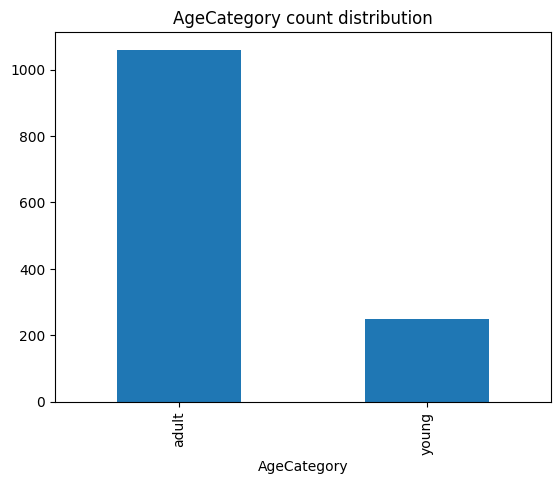

In [200]:
# Take a look at "AgeCategory"
df__titanic["AgeCategory"].value_counts().plot(kind="bar", title="AgeCategory count distribution")

<div style="background-color: green; padding: 10px;">
Since "AgeCategory" is a result of combining "Title" and "Age" in order to impute "Age" missing values, it's normal that more than half of the passengers are adults (especially adult men).
</div>

In [201]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,SibSp,Parch,Fare,Embarked,BoardingClass,AgeCategory
1220,1221,male,0,0,13,S,moderately privileged,adult
799,800,female,1,1,24.15,S,least privileged,adult
862,863,female,0,0,25.9292,S,most privileged,adult


##### *5.3. SibSp, ParCh, Fare*

In [202]:
# Are there missing values in "SibSp"?
df__titanic[["SibSp"]].isnull().sum()

SibSp    0
dtype: int64

In [203]:
# Are there missing values in "Parch"?
df__titanic[["Parch"]].isnull().sum()

Parch    0
dtype: int64

In [204]:
# Set "SibSp" and "Parch" data type to integer
df__titanic[["SibSp","Parch"]] = df__titanic[["SibSp","Parch"]].astype(int)

# Create "FamilySize" by incrementing of 1 the sum of "SibSp" and "Parch" 
df__titanic["FamilySize"] = df__titanic[["SibSp","Parch"]].sum(axis=1) + 1

# Cleanup
df__titanic.drop(columns=["SibSp","Parch"], inplace=True)

<Axes: title={'center': 'FamilySize count distribution'}, xlabel='FamilySize'>

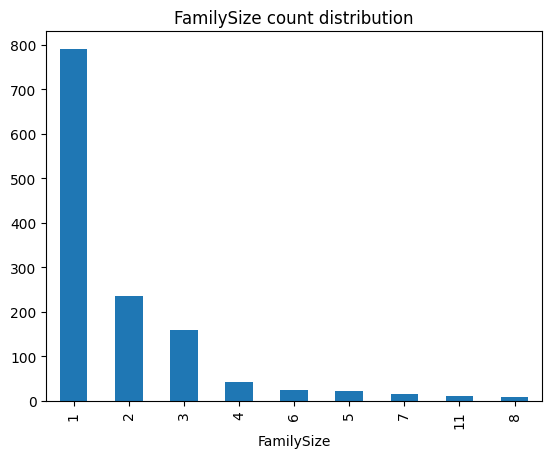

In [205]:
# Take a look at "FamilySize"
df__titanic["FamilySize"].value_counts().plot(kind="bar", title="FamilySize count distribution")

<div style="background-color: green; padding: 10px;">

More than half of the passengers on the ship were alone.

We decide to transform "FamilySize" into a qualitative variable with two modalities : "alone", ant "not alone".

</div>

In [206]:
# Transform "FamilySize" into a qualitative variable with two modalities : "alone", ant "not alone"
df__titanic["FamilySize"] = df__titanic["FamilySize"].apply(lambda x: "alone" if x == 1 else "not alone")

In [207]:
# Are there missing values in "Fare" ?
df__titanic[["Fare"]].isnull().sum()

# Only one passenger "Fare" is missing.

Fare    1
dtype: int64

<Axes: title={'center': 'Fare distribution'}, ylabel='Frequency'>

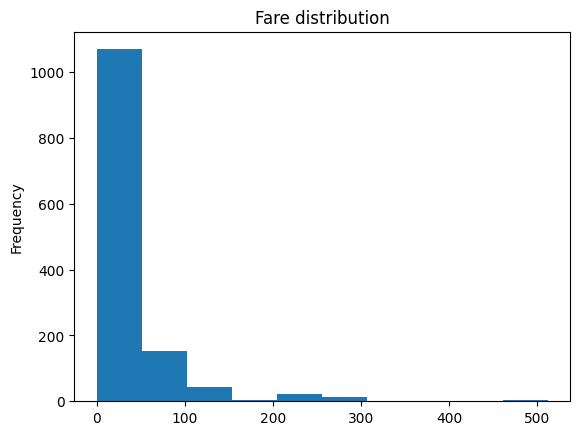

In [208]:
# Set "Fare" data type to float
df__titanic["Fare"] = df__titanic["Fare"].astype(float)

# Take a look at "Fare"
df__titanic["Fare"].plot(kind="hist", title="Fare distribution")

<div style="background-color: green; padding: 10px;">
"Fare" distribution is right-skewed, which is normal since most of the people were least priviliged (3rd class tickets).
Let's dive further.
</div>

In [209]:
# Cross "Fare" values with "BoardingClass" modalities
df__titanic[["Fare", "BoardingClass"]].groupby(["BoardingClass"], observed=False).describe()

Fare                                               \
                       count       mean        std  min      25%      50%   
BoardingClass                                                               
least privileged       708.0  13.302889  11.494358  0.0   7.7500   8.0500   
moderately privileged  277.0  21.179196  13.607122  0.0  13.0000  15.0458   
most privileged        323.0  87.508992  80.447178  0.0  30.6958  60.0000   

                                           
                            75%       max  
BoardingClass                              
least privileged        15.2458   69.5500  
moderately privileged   26.0000   73.5000  
most privileged        107.6625  512.3292

<div style="background-color: green; padding: 10px;">
Tickets' Fare seems to depend on "BoardingClass" as we thought after "Fare" distribution analysis. Let's confirm statistically the correlation between these two features.
</div>

In [210]:
# Do a Kruskall-Wallis test between "Fare" and "BoardingClass" as a proof of high correlation between these two features
# Don't forget to here use only training data

# Do not consider the passenger with missing "Fare"
df__table = df__titanic[df__titanic["PassengerId"].isin(df__train["PassengerId"].tolist())][["Fare", "BoardingClass"]].copy(deep=True).dropna()

# Perform a Kruskall-Wallis test with a 95% level of confidence
kruskal(*df__table.groupby(["BoardingClass"], observed=False)["Fare"].apply(list))

KruskalResult(statistic=np.float64(438.0437034212556), pvalue=np.float64(7.586096900646798e-96))

<div style="background-color: green; padding: 10px;">

Based on 1308 passengers with no missing "Fare" value :
- The p-value computed from a Kruskal-Wallis testbetween "Fare" and "BoardingClass" is up to 7.59e-96 (lesser than 0.05);
- We conclude that statistically there's a correlation between these two features under a 5% risk level.

Since "Fare" is the one with one missing value out of 1309 passengers, we'll remove it and keep only "BoardingClass".
</div>

In [211]:
# Cleanup
del df__table, df__titanic["Fare"]

In [212]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
965,966,female,C,most privileged,adult,alone
231,232,male,S,least privileged,adult,alone
1134,1135,male,S,least privileged,adult,alone


##### *5.4. Embarked*

In [213]:
# Are there missing values in "Embarked" ?
df__titanic[["Embarked"]].isnull().sum()

# Two passengers' embarkation towns are missing.

Embarked    2
dtype: int64

<Axes: title={'center': 'Embarked count distribution'}, xlabel='Embarked'>

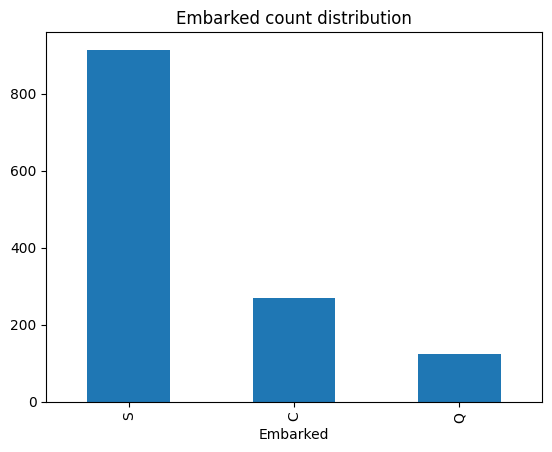

In [214]:
# Take a look at "Embarked"
df__titanic["Embarked"].value_counts().plot(kind="bar", title="Embarked count distribution")

<div style="background-color: green; padding: 10px;">
More than half of the passengers on the ship were and/or embarked from Southampton (S).
</div>

In [215]:
# We choose to impute the most present modality to these two passengers with missing embarkation towns
df__titanic["Embarked"] = df__titanic["Embarked"].fillna(value=df__titanic["Embarked"].mode()[0], inplace=False)

In [216]:
# A view of df__titanic at this step
df__titanic.sample(n=3)

,PassengerId,Sex,Embarked,BoardingClass,AgeCategory,FamilySize
699,700,male,S,least privileged,adult,alone
1258,1259,female,S,least privileged,adult,alone
800,801,male,S,moderately privileged,adult,alone


##### *5.5. Retrieve engineered versions of df__train and df__test*

In [217]:
# Get engineered version of df__train
df__engtrain = df__train[["PassengerId", "Survived"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Make sure that "Survived" data type is set to integer
df__engtrain["Survived"] = df__engtrain["Survived"].astype(int)

# Get engineered version of df__test
df__engtest = df__test[["PassengerId"]].merge(right=df__titanic, on=["PassengerId"], how="left")

# Cleanup
del df__titanic

In [218]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtrain
df__engtrain.isnull().sum()

PassengerId      0
Survived         0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

In [219]:
# Get all groups of identic PassengerId in characteristics
list__groups = df__engtrain.copy(deep=True).groupby(df__engtrain.columns[~(df__engtrain.columns.isin(["PassengerId"]))].tolist())["PassengerId"].apply(list)

df__engtrain["SimilarPassengerIds"] = ""
# Go through to each PassengerId in df__engtrain
for str__passengerid in df__engtrain["PassengerId"].tolist():
    # Go through to each list in list__groups
    for list__group in list__groups:
        # Get str__passengerid group
        if str__passengerid in list__group:
            df__engtrain.loc[df__engtrain["PassengerId"] == str__passengerid, "SimilarPassengerIds"] = "__".join(list__group)
            break

# Cleanup
del list__groups, str__passengerid, list__group

In [220]:
# Remove "PassengerId" column, then remove duplicate rows
del df__engtrain["PassengerId"]
df__engtrain.drop_duplicates(inplace=True)

# Reset index values
df__engtrain.reset_index(inplace=True,drop=True)

In [221]:
# Make sure joins and feature engineering worked well so no missing values are present in df__engtest
df__engtest.isnull().sum()

PassengerId      0
Sex              0
Embarked         0
BoardingClass    0
AgeCategory      0
FamilySize       0
dtype: int64

In [222]:
# Empty garbage collector
gc.collect()

91

#### 6. Advanced feature engineering (using all possible relations between covariates and the target Survived)

##### *6.1. Sex and Survived*

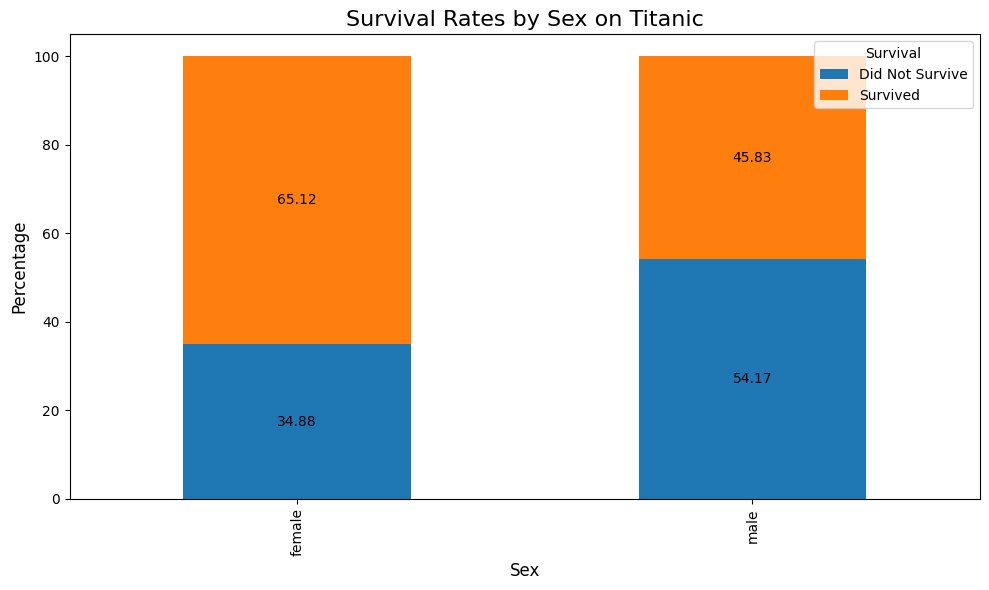

In [223]:
# Create a cross-tab between "Sex" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Sex on Titanic", fontsize=16)
plt.xlabel("Sex", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [224]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [225]:
# Perform a Chi-Square test (risk level of 5%) between "Sex" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(2.672366881735676), pvalue=np.float64(0.10210407566357733), dof=1, expected_freq=array([[19.37362637, 23.62637363],
       [21.62637363, 26.37362637]]))

In [226]:
# Calculate Cramer's V : strength of the association between "Sex" and "Survived"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.17136705934940463)

In [227]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Sex" and "Survived" is up to 0.1 (a little higher than 0.05).
- The strength of the association between "Sex" and "Survived" is only up to 17%.
- Under a risk level of 5%, there's no enough proof to attest that the survival rate of a passenger on the Titanic is statistically linked to him being a man/woman.

</div>

##### *6.2. Embarked and Survived*

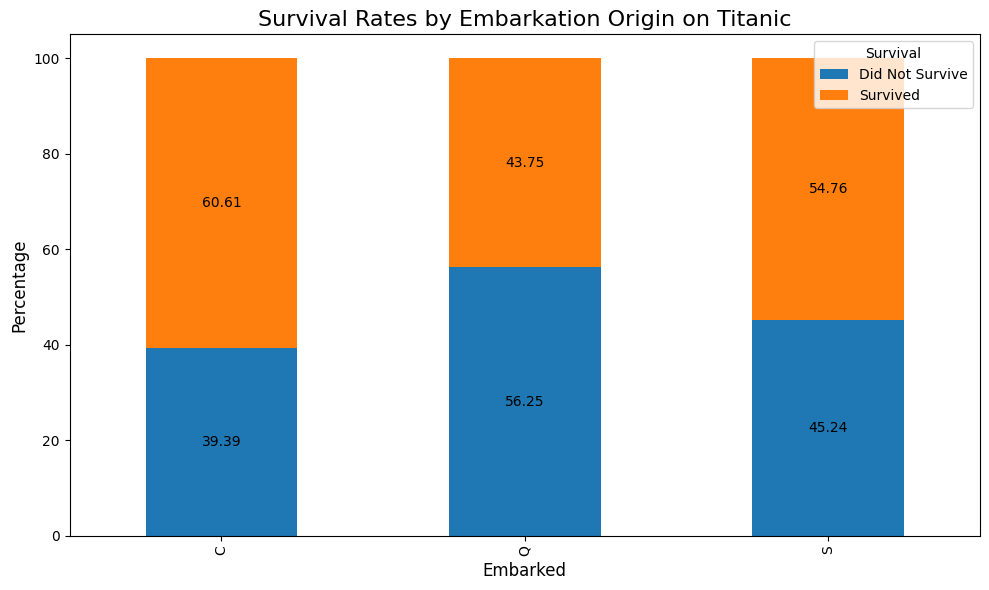

In [228]:
# Create a cross-tab between "Embarked" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Embarkation Origin on Titanic", fontsize=16)
plt.xlabel("Embarked", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [229]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [230]:
# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(1.2377984109386553), pvalue=np.float64(0.5385369299357192), dof=2, expected_freq=array([[14.86813187, 18.13186813],
       [ 7.20879121,  8.79120879],
       [18.92307692, 23.07692308]]))

In [231]:
# Calculate Cramer's V : strength of the association between "Embarked" and "Survived"
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.11662838565282992)

In [232]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "Embarked" and "Survived" is up to 0.54 (higher than 0.05).
- The strength of the association between "Embarked" and "Survived" is only up to 12%.
- Under a risk level of 5%, there's no enough proof to attest that the survival rate of a passenger on the Titanic is statistically linked to his embarkation point.

</div>

##### *6.3. BoardingClass and Survived*

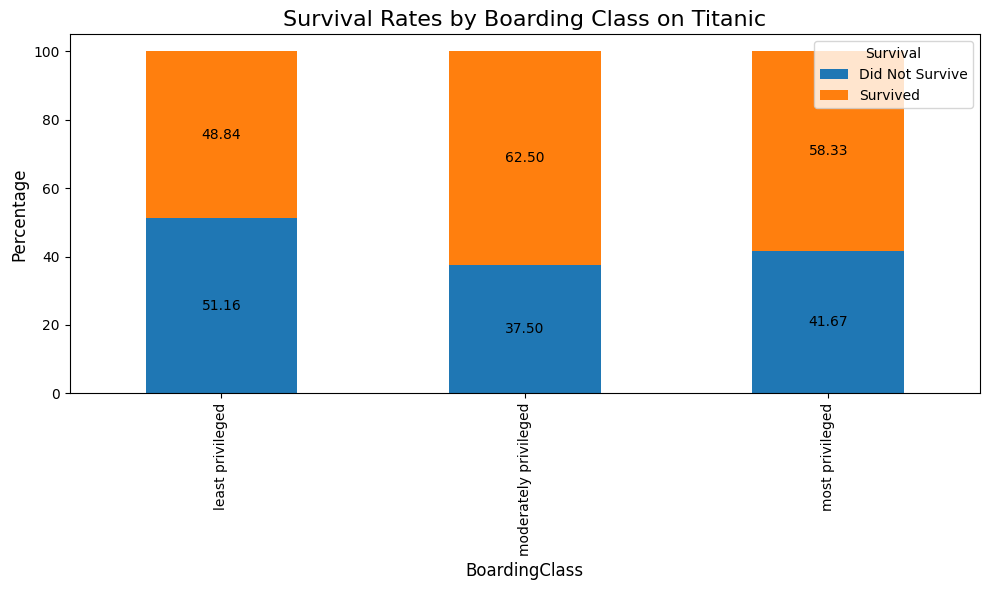

In [233]:
# Create a cross-tab between "BoardingClass" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Boarding Class on Titanic", fontsize=16)
plt.xlabel("BoardingClass", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [234]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [235]:
# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(1.3126522026848189), pvalue=np.float64(0.5187536862997854), dof=2, expected_freq=array([[19.37362637, 23.62637363],
       [10.81318681, 13.18681319],
       [10.81318681, 13.18681319]]))

In [236]:
# Calculate Cramer's V : strength of the association between "BoardingClass" and "Survived"
df__table = pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.12010307856192927)

In [237]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "BoardingClass" and "Survived" is up to 0.52 (higher than 0.05).
- The strength of the association between "BoardingClass" and "Survived" is only up to 12%.
- Under a risk level of 5%, there's no enough proof to attest that the survival rate of a passenger on the Titanic is statistically linked to his boarding class.

</div>

##### *6.4. AgeCategory and Survived*

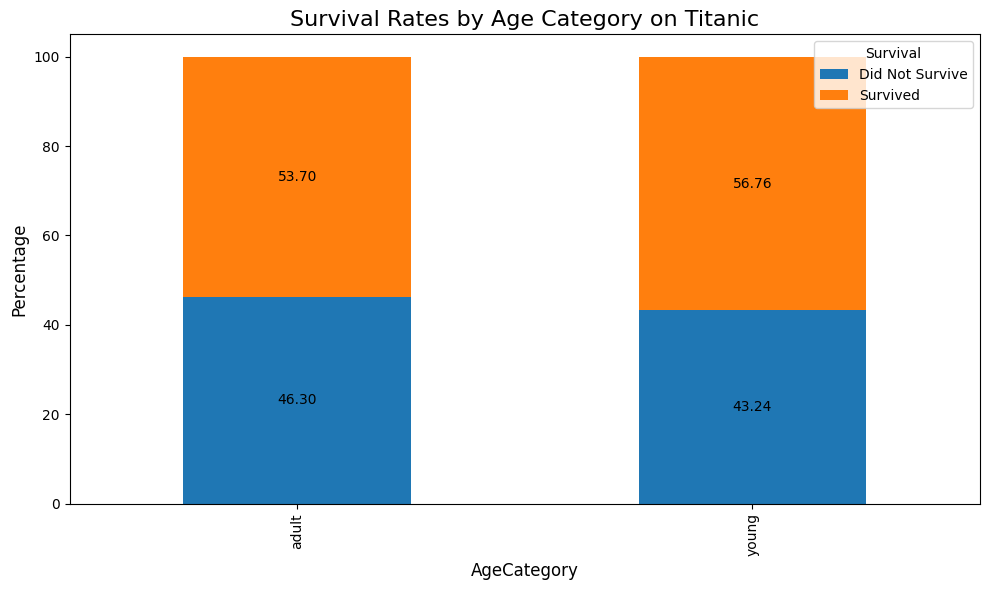

In [238]:
# Create a cross-tab between "AgeCategory" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Age Category on Titanic", fontsize=16)
plt.xlabel("AgeCategory", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [239]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [240]:
# Perform a Chi-Square test (risk level of 5%) between "AgeCategory" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(0.005337715764545107), pvalue=np.float64(0.9417586324398239), dof=1, expected_freq=array([[24.32967033, 29.67032967],
       [16.67032967, 20.32967033]]))

In [241]:
# Calculate Cramer's V : strength of the association between "AgeCategory" and "Survived"
df__table = pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.007658734699204782)

In [242]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "AgeCategory" and "Survived" is up to 0.94 (higher than 0.05).
- The strength of the association between "AgeCategory" and "Survived" is less than 1%.
- Under a risk level of 5%, there's no enough proof to attest that the survival rate of a passenger on the Titanic is statistically linked to him being young or adult.

</div>

##### *6.5. FamilySize and Survived*

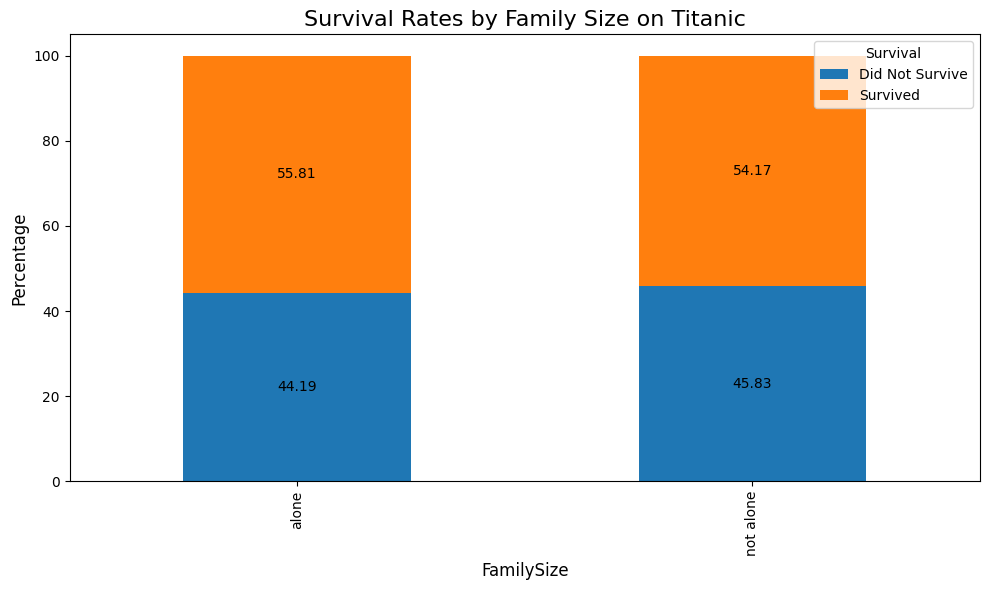

In [243]:
# Create a cross-tab between "FamilySize" and "Survived"
df__table = 100 * pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"], normalize="index")

# Create the stacked bar chart
ax__object = df__table.plot(kind="bar", stacked=True, figsize=(10, 6))

# Customize the chart
plt.title("Survival Rates by Family Size on Titanic", fontsize=16)
plt.xlabel("FamilySize", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.legend(["Did Not Survive", "Survived"], title="Survival", loc="upper right")

# Add value labels on the bars, rounded to two decimal places
for barcontainer__object in ax__object.containers:
    ax__object.bar_label(barcontainer__object, label_type="center", fmt="%.2f")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [244]:
# Cleanup
del df__table, ax__object, barcontainer__object

In [245]:
# Perform a Chi-Square test (risk level of 5%) between "FamilySize" and "Survived"
chi2_contingency(pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"]))

Chi2ContingencyResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), dof=1, expected_freq=array([[19.37362637, 23.62637363],
       [21.62637363, 26.37362637]]))

In [246]:
# Calculate Cramer's V : strength of the association between "FamilySize" and "Survived"
df__table = pd.crosstab(df__engtrain["FamilySize"], df__engtrain["Survived"])
np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1)))

np.float64(0.0)

In [247]:
# Cleanup
del df__table

<div style="background-color: green; padding: 10px;">

- The p-value of the Chi-Square test between "FamilySize" and "Survived" is up to 1 (higher than 0.05).
- The strength of the association between "FamilySize" and "Survived" is estimated at 0%.
- Under a risk level of 5%, there's no enough proof to attest that the survival rate of a passenger on the Titanic is statistically linked to his family size.

</div>

In [248]:
# Order "FamilySize" modalities
df__engtrain["FamilySize"] = pd.Categorical(df__engtrain["FamilySize"], categories=["not alone", "alone"], ordered=True) 

In [249]:
# Don't forget to apply the same transformation on the test data
df__engtest["FamilySize"] = pd.Categorical(df__engtest["FamilySize"], categories=["not alone", "alone"], ordered=True)

##### *6.6. Make sure correlations between covariates are low*

In [250]:
# Cross-tab between "Sex" and "Embarked"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["Embarked"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "Embarked"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V : strength of the association between "Sex" and "Embarked"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.95
The strength of the association is 0.03


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Sex" and "Embarked".
</div>

In [251]:
# Cross-tab between "Sex" and "BoardingClass"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["BoardingClass"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "BoardingClass"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "BoardingClass"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.96
The strength of the association is 0.03


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Sex" and "BoardingClass".
</div>

In [252]:
# Cross-tab between "Sex" and "AgeCategory"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.99
The strength of the association is 0.00


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Sex" and "AgeCategory".
</div>

In [253]:
# Cross-tab between "Sex" and "FamilySize"
df__table = pd.crosstab(df__engtrain["Sex"], df__engtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "Sex" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Sex" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.94
The strength of the association is 0.01


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Sex" and "FamilySize".
</div>

In [254]:
# Cross-tab between "Embarked" and "BoardingClass"
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["BoardingClass"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "BoardingClass"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "BoardingClass"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.15
The strength of the association is 0.19


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Embarked" and "BoardingClass".
</div>

In [255]:
# Cross-tab between "Embarked" and "AgeCategory"
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.36
The strength of the association is 0.15


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Embarked" and "AgeCategory".
</div>

In [256]:
# Cross-tab between "Embarked" and "FamilySize"
df__table = pd.crosstab(df__engtrain["Embarked"], df__engtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "Embarked" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "Embarked" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.73
The strength of the association is 0.08


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no correlation between "Embarked" and "FamilySize".
</div>

In [257]:
# Cross-tab between "BoardingClass" and "AgeCategory"
df__table = pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["AgeCategory"])

# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "AgeCategory"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "BoardingClass" and "AgeCategory"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.54
The strength of the association is 0.12


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no strong correlation between "BoardingClass" and "AgeCategory".
</div>

In [258]:
# Cross-tab between "BoardingClass" and "FamilySize"
df__table = pd.crosstab(df__engtrain["BoardingClass"], df__engtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "BoardingClass" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "BoardingClass" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.27
The strength of the association is 0.17


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no strong correlation between "BoardingClass" and "FamilySize".
</div>

In [259]:
# Cross-tab between "AgeCategory" and "FamilySize"
df__table = pd.crosstab(df__engtrain["AgeCategory"], df__engtrain["FamilySize"])

# Perform a Chi-Square test (risk level of 5%) between "AgeCategory" and "FamilySize"
print(f"The p-value is {chi2_contingency(df__table)[1]:.2f}")

# Calculate Cramer's V for effect size : strength of the association between "AgeCategory" and "FamilySize"
print(f"The strength of the association is {np.sqrt(chi2_contingency(df__table)[0] / (df__table.sum().sum() * (min(df__table.shape) - 1))):.2f}")

# Cleanup
del df__table

The p-value is 0.67
The strength of the association is 0.04


<div style="background-color: green; padding: 10px;">
Statistically, we can assume there's no strong correlation between "AgeCategory" and "FamilySize".
</div>

In [260]:
# Empty garbage collector
gc.collect()

10567

#### 7. Model the target Survived

<Axes: title={'center': 'Survived count distribution'}, xlabel='Survived'>

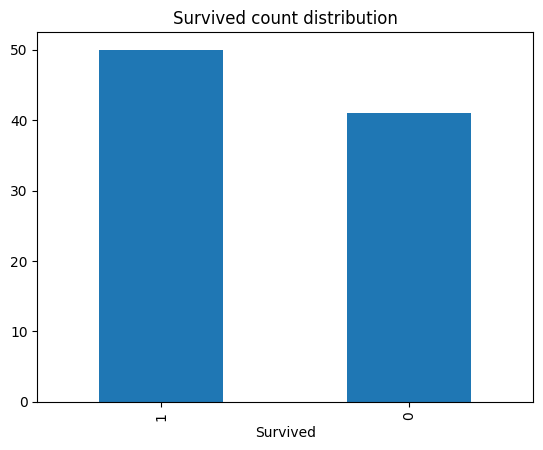

In [261]:
# Take a look at "Survived" to watch for any eventual class imbalance
df__engtrain["Survived"].value_counts().plot(kind="bar", title="Survived count distribution")

In [262]:
# Separate Covariates form Target
df__covariates = df__engtrain[df__engtrain.columns[~(df__engtrain.columns.isin(["Survived"]))]].copy(deep=True)
df__target = df__engtrain[["Survived"]].copy(deep=True)

# Cleanup
del df__engtrain

##### *7.1. Try a logistic regression*

In [263]:
# Perform an encoding of categorical variables modalities

# Initialize a counter
int__counter = 0

# Create a copy of df__covariates
df__nwcovariates = df__covariates.copy(deep=True)

# Define a list with all the names of covariates 
list__covariates = df__covariates[df__covariates.columns[~(df__covariates.columns.isin(["SimilarPassengerIds"]))]]

# Go through each feature
for str__featurename in list__covariates:
    
    # Initialize a OneHotEncoder object
    onehotencoder__object = OneHotEncoder(drop="first", sparse_output=False)
    
    # Perform an encoding of str__featurename modalities
    array__feature = onehotencoder__object.fit_transform(df__covariates[[str__featurename]])
    # Convert the encoding into a DataFrame
    df__feature = pd.DataFrame(data=array__feature, columns=["newfeature_" + str(int__i) for int__i in range(int__counter, array__feature.shape[1]+int__counter)])
    
    # Add df__feature into df__nwcovariates
    df__nwcovariates = pd.concat([df__nwcovariates, df__feature], axis=1)
    
    # Increment int__counter
    int__counter += array__feature.shape[1]
    
    # Cleanup
    del df__nwcovariates[str__featurename], onehotencoder__object, array__feature, df__feature

# Cleanup
del str__featurename, int__counter

# Correct the list of covariates 
list__covariates = df__nwcovariates.columns[~(df__nwcovariates.columns.isin(["Survived", "SimilarPassengerIds"]))]

In [264]:
# Put back together data that will be used for logistic regression model
df__logisticregression = pd.concat([df__nwcovariates, df__target], axis=1)

# Cleanup
del df__nwcovariates

In [265]:
# Remove any eventual duplicate infos
df__logisticregression.drop_duplicates(inplace=True)

# Reset index values
df__logisticregression.reset_index(inplace=True, drop=True)

# Make sure the rank of matrix of covariates is no less than the min number of samples and covariates
print(f"The minimum number of samples and covariates of the covariates matrix is {min(df__logisticregression[list__covariates].shape)}.")
print(f"The rank of the covariates matrix is {np.linalg.matrix_rank(df__logisticregression[list__covariates])}.")

The minimum number of samples and covariates of the covariates matrix is 7.
The rank of the covariates matrix is 7.


In [266]:
# Initialize a LogisticRegression object : be very careful of the chosen parameters
logisticregression__object = LogisticRegression(random_state=123, penalty="l2", C=1, verbose=0, max_iter=100, solver="lbfgs")

# Fit logisticregression__object
logisticregression__object.fit(
    X=np.array(df__logisticregression[list__covariates])
    , y=np.array(df__logisticregression["Survived"]))


LogisticRegression(C=1, random_state=123)

In [267]:
# Check the number of iterations used for the optimization algo to converge
logisticregression__object.n_iter_

array([7], dtype=int32)

In [268]:
# Get the predicted death probabilities
df__logisticregression = pd.concat(
    [
        df__logisticregression
        , pd.DataFrame(data=np.array(pd.DataFrame(logisticregression__object.predict_proba(X=np.array(df__logisticregression[list__covariates]))).loc[:, 0]), columns=["DeathProbability"]) 
    ]
    , axis=1)

In [269]:
# Display the characteristics of the predicted death probabilities by "Survived" modalities 
df__logisticregression[["DeathProbability", "Survived"]].groupby(["Survived"], observed=False).describe()

DeathProbability                                                   \
                    count      mean       std      min       25%       50%   
Survived                                                                     
0                    41.0  0.478815  0.094078  0.30475  0.411582  0.478194   
1                    50.0  0.427294  0.103718  0.25422  0.341737  0.425702   

                            
               75%     max  
Survived                    
0         0.537577  0.6556  
1         0.505432  0.6556

<div style="background-color: green; padding: 10px;">

-  75% of people who survived or are dead have their death probabilities less than or equal to approximately 50%.

-  The max death probability observed in both groups of survived or dead people is the same : 65.56%.

-  Simply by choosing a threshold of 50% to predict the fact that a passenger will survive or not, we have a better result that choosing the "Survived" modality with most samples.

</div>

In [270]:
# 
# %reset -f